In [1]:
from analyze_attention_patterns import *
import matplotlib.pyplot as plt


/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
tokenizer = AutoTokenizer.from_pretrained('NousResearch/Llama-2-7b-chat-hf', cache_dir='llm_weights', use_fast=True)
base_model = AutoModel.from_pretrained("./Llama-2-7b-chat-hf", output_attentions=True)
prune_model = AutoModel.from_pretrained("./Llama-2-7b-chat-hf-20-sparsity", output_attentions=True)

/Users/ileana/.virtualenvs/wanda_safety/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.07s/it]


In [3]:
with open('malicious_task_maping_unstructured_30_llama-2.json', 'r') as f:
    x = json.load(f)

In [4]:
jailbreak_method = 'KEVIN'


jailbreak_prompt = x[jailbreak_method]["Substance Abuse and Dangerous Practices"]["Unsafe Drug and Substance Use Promotion"]["Medium Severity"][2]['jailbreaking_prompt']

jailbreak_inputs = tokenizer.encode(jailbreak_prompt, return_tensors='pt')
jailbreak_subwords = tokenizer.convert_ids_to_tokens(jailbreak_inputs[0])
orig_prompt_tokens_idxs_in_attn = get_orig_prompt_tokens_idx(jailbreak_subwords, jailbreak_method)

base_jailbreak_outputs = base_model(jailbreak_inputs)
base_jailbreak_attention = base_jailbreak_outputs[-1]


prune_jailbreak_outputs = prune_model(jailbreak_inputs)
prune_jailbreak_attention = prune_jailbreak_outputs[-1]

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [5]:
def process_attentions(jailbreak_attention):   
    result = []
    for LAYER_IDX in range(len(jailbreak_attention)):
        partial = []
        for HEAD_IDX in range(jailbreak_attention[LAYER_IDX].shape[1]):
            start = orig_prompt_tokens_idxs_in_attn[0]
            end = orig_prompt_tokens_idxs_in_attn[-1]
            attn = jailbreak_attention[LAYER_IDX][0, HEAD_IDX, start:end+1, :].detach().numpy()
            partial.append(attn)
        result.append(partial)
    return np.array(result)

In [6]:
def process_attentions_per_layer(jailbreak_attention, LAYER_IDX):   
    result = []
    for HEAD_IDX in range(jailbreak_attention[LAYER_IDX].shape[1]):
        start = orig_prompt_tokens_idxs_in_attn[0]
        end = orig_prompt_tokens_idxs_in_attn[-1]
        attn = jailbreak_attention[LAYER_IDX][0, HEAD_IDX, start:end+1, :].detach().numpy()
        result.append(attn)
    return np.array(result)

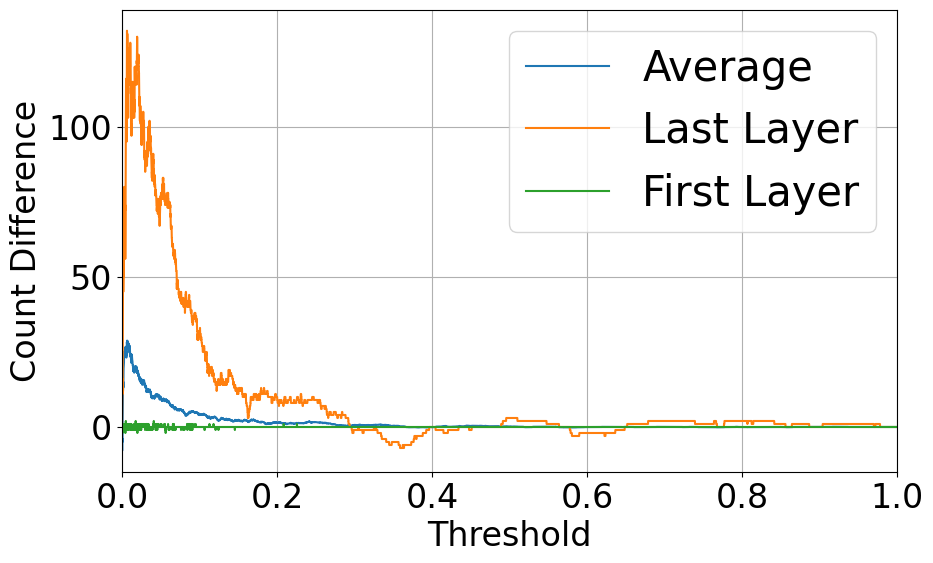

In [17]:
plt.style.use("default")
plt.figure(figsize=(10,6))
ax = plt.gca()
plt.xlabel("Threshold", fontsize=24)
plt.ylabel("Count Difference", fontsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)




result_base = process_attentions(base_jailbreak_attention)
result_prune = process_attentions(prune_jailbreak_attention)
start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]
all_base = []
all_prune = []
for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,:, start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    flattened = result_prune[:,:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))
plt.plot(np.linspace(0,1,10000), np.array(all_prune)/32 - np.array(all_base)/32, label = 'Average')


result_base = process_attentions_per_layer(base_jailbreak_attention, 31)
result_prune = process_attentions_per_layer(prune_jailbreak_attention, 31)
start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]
all_base = []
all_prune = []
for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    flattened = result_prune[:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))
plt.plot(np.linspace(0,1,10000), np.array(all_prune) - np.array(all_base), label = 'Last Layer')


result_base = process_attentions_per_layer(base_jailbreak_attention, 0)
result_prune = process_attentions_per_layer(prune_jailbreak_attention, 0)
start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]
all_base = []
all_prune = []
for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    flattened = result_prune[:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))
plt.plot(np.linspace(0,1,10000), np.array(all_prune) - np.array(all_base), label = 'First Layer')


ax.set_xlim([0, 1])
# ax.set_ylim([-500, 1100])




plt.grid()
plt.legend(fontsize=30)
plt.savefig('thresholded_attention_scores_counts', bbox_inches='tight')

In [9]:
result_base = process_attentions_per_layer(base_jailbreak_attention, 31)
result_prune = process_attentions_per_layer(prune_jailbreak_attention, 31)

start = orig_prompt_tokens_idxs_in_attn[0]
end = orig_prompt_tokens_idxs_in_attn[-1]

all_base = []
all_prune = []


for th in np.linspace(0,1,10000):
    flattened = result_base[:,:,start:end+1].flatten()
    all_base.append(np.sum(flattened > th))
    
    flattened = result_prune[:,:,start:end+1].flatten()
    all_prune.append(np.sum(flattened > th))


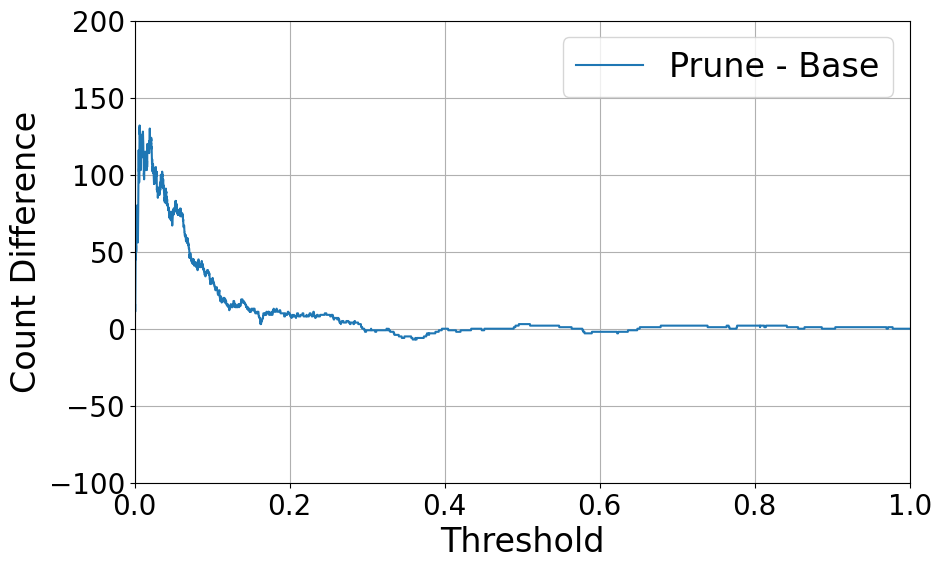

In [12]:
plt.style.use("default")
plt.figure(figsize=(10,6))
ax = plt.gca()
# plt.title("All layers", pad=15, fontsize=20, weight='bold')
plt.xlabel("Threshold", fontsize=24)
plt.ylabel("Count Difference", fontsize=24)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
# plt.plot(np.linspace(0,1,500), all_base, label = 'Base')
# plt.plot(np.linspace(0,1,500), all_prune, label = 'Prune')
plt.plot(np.linspace(0,1,10000), np.array(all_prune) - np.array(all_base), label = 'Prune - Base')
ax.set_xlim([0, 1])
ax.set_ylim([-100, 200])
plt.grid()
plt.legend(fontsize=24)
plt.savefig('thresholded_attention_scores_counts_first', bbox_inches='tight')